# Task 2 - Car Price Prediction

### Submitted by:
- Yarden Ohana - 315321851
- Amit Sasson - 322759648

github
https://github.com/yardenochana/project-/blob/8d651e6b51225f47ad6431cfd927e2c61c952e8e/%D7%9E%D7%98%D7%9C%D7%AA%20%D7%A1%D7%99%D7%9B%D7%95%D7%9D-%20%D7%97%D7%9C%D7%A7%201%20%2B%20%D7%A8%D7%A9%D7%95%D7%AA%20%D7%99%D7%A8%D7%93%D7%9F%20%D7%95%D7%A2%D7%9E%D7%99%D7%AA.ipynb

In our project, we chose to follow these steps:
1. Manually remove columns based on our judgment.
2. Examine outliers in relevant columns and understand the data to know how to clean and organize it.
3. Build a predictive model using cross-validation and Elastic Net that will select the 5 columns that most influence the price.
4. Evaluate the performance of our training model on reality.

After selecting the columns, we began cleaning and organizing the data by addressing missing values and outliers based on both our judgment and predictions, approximating to minimize RMSE.

# Import Libraries and Set Up Variables

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import ppscore as pps
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # להתעלם מכל האזהרות
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from math import sqrt
from sklearn.linear_model import ElasticNetCV

# Read the dataset

In [4]:
file_name = 'dataset.csv'
df = pd.read_csv(file_name)

# Checking for Outliers

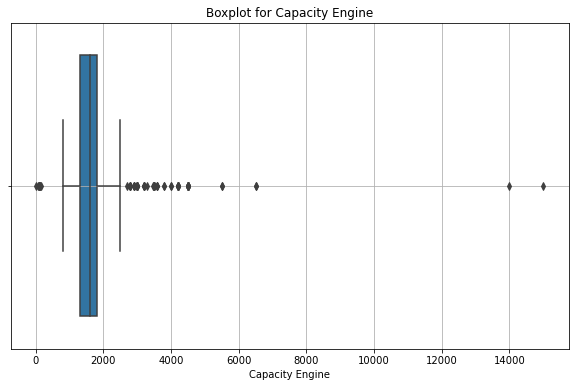

count     1316.000000
mean      1672.692249
std        799.180730
min         13.000000
25%       1299.500000
50%       1599.000000
75%       1800.000000
max      15000.000000
Name: capacity_Engine, dtype: float64

In [5]:
# Convert non-numeric values in 'capacity_Engine' to numeric, setting errors='coerce' to convert invalid parsing to NaN
df['capacity_Engine'] = pd.to_numeric(df['capacity_Engine'], errors='coerce')

# Creating a more styled boxplot for the 'capacity_Engine' column after handling outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['capacity_Engine'])
plt.title('Boxplot for Capacity Engine')
plt.xlabel('Capacity Engine')
plt.grid(True)
plt.show()

# Calculating boxplot statistics for 'capacity_Engine' after handling outliers
capacity_engine_stats_replaced = df['capacity_Engine'].describe(percentiles=[.25, .5, .75])
capacity_engine_stats_replaced

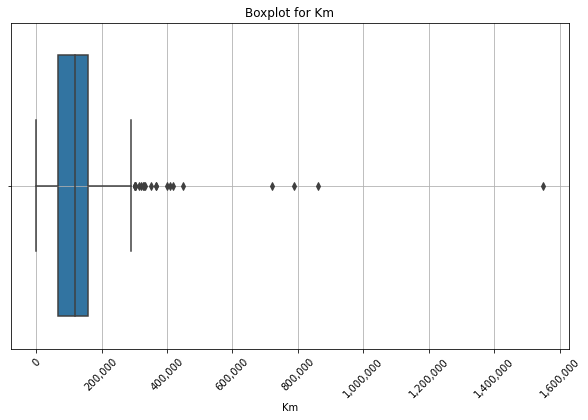

count    1.324000e+03
mean     1.200579e+05
std      8.666751e+04
min      0.000000e+00
25%      6.600000e+04
50%      1.200000e+05
75%      1.600000e+05
max      1.550000e+06
Name: Km, dtype: float64

In [6]:
# Convert non-numeric values in 'Km' to numeric, setting errors='coerce' to convert invalid parsing to NaN
df['Km'] = pd.to_numeric(df['Km'], errors='coerce')

# Creating a more styled boxplot for the 'Km' column after handling outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Km'])
plt.title('Boxplot for Km')
plt.xlabel('Km')
plt.xticks(rotation=45)
plt.grid(True)

# Setting the format of the x-axis to display real numbers
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.show()

# Calculating boxplot statistics for 'Km' after handling outliers
km_stats_replaced = df['Km'].describe(percentiles=[.25, .5, .75])
km_stats_replaced


We built a function named `prepare_data()` 
that contains all the code for cleaning and organizing the data, with explanatory comments for each code section.

By inputting any data into this function, we will receive cleaned data according to the cleaning and organizing procedures we implemented.

### Roadmap for the prepare_data() Function

1. We started by independently removing columns based on our judgment.
2. We standardized the format of the model column.
3. We realized that there is a lot of information in the vehicle description that can be extracted, making the data more accurate. Therefore, we wrote code to extract data from the description.
4. We checked how many missing values each column had. If a column had more than 50% missing values, we decided to remove it. If there are more artificial values than real ones, it will not reflect reality.
5. We manually standardized (as much as possible) words with the same meaning but different spellings.
6. We filled in missing values and organized outliers for all columns (including columns in the original data with no missing values because we don’t know how the test data will be).
7. We removed the description column and other auxiliary columns we built.
8. We will elaborate later on how we chose to fill in missing values.

# `prepare_data()` Function for Data Preprocessing

In [11]:
def prepare_data(file_path):
    
    # Read the dataset
    df = pd.read_csv(file_path)
    
    # Columns to drop
    columns_to_drop = ['Area', 'City', 'Pic_num', 'Cre_date', 'Repub_date', 'Color']
    df_dropped = df.drop(columns=columns_to_drop)
    
    # Standardize data by removing the 'manufactor' word from 'model' and removing years (numbers in parentheses)
    df_dropped['model'] = df_dropped.apply(lambda row: re.sub(r'\(\d{4}\)', '', row['model'].replace(row['manufactor'], '').strip()).strip(), axis=1)
    
    # Function to extract information from the 'Description' column
    def extract_info(description, unique_manufactors, unique_models):
        info = {}
        
        # Extract manufactor
        for manufactor in unique_manufactors:
            if re.search(manufactor, description):
                info['manufactor'] = manufactor
        
        # Extract Year
        year_match = re.search(r'שנה\s(198[0-9]|199[0-9]|200[0-9]|201[0-9]|202[0-4])\b', description)
        if year_match:
            info['Year'] = int(year_match.group(1))
        
        # Extract model
        for model in unique_models:
            if re.search(model, description, re.IGNORECASE):
                info['model'] = model
        
        # Extract Hand
        hand_match = re.search(r'\b(\d+)\s*יד\b', description)
        if hand_match:
            info['Hand'] = int(hand_match.group(1))
        
        # Extract Gear
        gears = ['אוטומטית', 'טיפטרוניק', 'ידנית', 'רובוטית', 'אוטומט', 'לא מוגדר']
        for gear in gears:
            if re.search(gear, description, re.IGNORECASE):
                info['Gear'] = gear
                break
        
        # Extract capacity_Engine
        capacity_engine_match = re.search(r'(?:(?:נפח|מנוע|נפח מנוע)\s*(\d+))', description)
        if capacity_engine_match:
            info['capacity_Engine'] = int(capacity_engine_match.group(1))
        
        # Extract Engine_type
        engine_types = ['בנזין', 'דיזל', 'גז', 'היברידי', 'היבריד', 'טורבו דיזל', 'חשמלי']
        for engine_type in engine_types:
            if re.search(engine_type, description, re.IGNORECASE):
                info['Engine_type'] = engine_type
                break
        
        return info

    def update_missing_values(row, columns_options, ownership_pattern):

        for column, options in columns_options.items():
            if pd.isna(row[column]):
                for option in options:
                    if option in row["Description"]:
                        if column == "Gear" and option in ["אוטומט", "אוטומטי"]:
                            row[column] = "אוטומטית"
                        elif column == "Engine_type":
                            if option == "היברידית":
                                row[column] = "היברידי"
                            elif option == "חשמלית":
                                row[column] = "חשמלי"
                            else:
                                row[column] = option
                        else:
                            row[column] = option
                        break
        
        # Update Prev_ownership and Curr_ownership if missing
        if pd.isna(row['Prev_ownership']) or pd.isna(row['Curr_ownership']):
            ownership_from_desc = find_ownership(row['Description'])
            if ownership_from_desc:
                if pd.isna(row['Prev_ownership']):
                    row['Prev_ownership'] = ownership_from_desc
                if pd.isna(row['Curr_ownership']):
                    row['Curr_ownership'] = ownership_from_desc
        
        return row

    def find_ownership(description):
        if pd.isna(description):
            return None
        match = re.search(ownership_pattern, description)
        if match:
            return match.group(0)
        return None

    def fill_values_from_description(df, unique_manufactors, unique_models, columns_options, ownership_pattern):
        for index, row in df.iterrows():
            if pd.notnull(row['Description']):
                extracted_info = extract_info(row['Description'], unique_manufactors, unique_models)
                for key, value in extracted_info.items():
                    if pd.isnull(row[key]):
                        df.at[index, key] = value
            update_missing_values(row, columns_options, ownership_pattern)
        return df

    # Define unique manufactors and models for extraction
    unique_manufactors = df['manufactor'].unique()
    unique_models = df['model'].unique()

    # Define columns options for missing values update
    columns_options = {
        'Gear': ['אוטומט', 'אוטומטי', 'ידני', 'רובוטי'],
        'Engine_type': ['בנזין', 'דיזל', 'היברידית', 'חשמלית']
    }

    # Define ownership pattern
    ownership_pattern = r'יד \d'
    
    # Define ownership types
    ownership_types = ['פרטית', 'השכרה', 'ליסינג', 'מונית', 'לימוד נהיגה', 'ייבוא אישי', 'ממשלתי']
    
    # Create ownership pattern
    ownership_pattern = '|'.join(ownership_types)
    
    # Find ownership type in description
    def find_ownership(description):
        if pd.isna(description):
            return None
        match = re.search(ownership_pattern, description)
        if match:
            return match.group(0)
        return None
    
    # List of rows where missing values were completed
    completed_rows = []
    
    # Fill missing values in Prev_ownership and Curr_ownership
    for index, row in df_dropped.iterrows():
        if pd.isna(row['Prev_ownership']) or pd.isna(row['Curr_ownership']):
            ownership_from_desc = find_ownership(row['Description'])
            if ownership_from_desc:
                if pd.isna(row['Prev_ownership']):
                    df_dropped.at[index, 'Prev_ownership'] = ownership_from_desc
                if pd.isna(row['Curr_ownership']):
                    df_dropped.at[index, 'Curr_ownership'] = ownership_from_desc
                completed_rows.append(index)

    # Fill values from description
    df_dropped = fill_values_from_description(df_dropped, unique_manufactors, unique_models, columns_options, ownership_pattern)

    # Count missing values in each column
    missing_values = df_dropped.isnull().sum()
    
    # Calculate the percentage of missing values
    missing_percentage = (missing_values / len(df_dropped)) * 100
    
    # Create a DataFrame to display the results more nicely
    missing_values_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
    
    # Filter columns with more than 50% missing values
    columns_to_drop = missing_percentage[missing_percentage > 50].index
    
    # Drop the columns from df_dropped
    df_dropped = df_dropped.drop(columns=columns_to_drop)
    
    # Replace inconsistent values in 'model' column
    df_dropped['model'] = df_dropped['model'].replace({
        "קאונטרימן": "קאנטרימן",
        "גראנד, וויאגר": "גראנד, וויאג'ר",
        "גטה": "ג'טה",
        "גאז": "ג'אז",
        "C-Class קופה": "C-CLASS קופה",
        "E-CLASS": "E-Class",
        "E- CLASS": "E-Class"
    })
    
    # Replace inconsistent values in 'Gear' column
    df_dropped['Gear'] = df_dropped['Gear'].replace("אוטומט", "אוטומטית")
    
    # Replace inconsistent values in 'Engine_type' column
    df_dropped['Engine_type'] = df_dropped['Engine_type'].replace("היבריד", "היברידי")
    
    # Replace inconsistent values in 'manufactor' column
    df_dropped["manufactor"] = df_dropped["manufactor"].replace("Lexsus", "לקסוס")
    
    # Fill missing values in Year and Hand columns
    
    # Add a column Years_Since_Year indicating the number of years the car has been on the road
    current_year = datetime.now().year
    df_dropped['Years_Since_Year'] = current_year - df_dropped['Year']
    
    # Step 1: Find rows with no missing values in Hand and Years_Since_Year columns
    valid_rows = df_dropped.dropna(subset=['Hand', 'Years_Since_Year'])
    
    # Step 2: Calculate the ratio and mean ratio
    ratios = valid_rows['Years_Since_Year'] / valid_rows['Hand']
    mean_ratio = ratios.mean()
    
    # Step 3: Fill missing values in Hand column
    df_dropped['Hand'] = df_dropped.apply(
        lambda row: row['Years_Since_Year'] / mean_ratio if pd.isnull(row['Hand']) else row['Hand'],
        axis=1
    )
    
    # Step 4: Fill missing values in Years_Since_Year and Year columns
    df_dropped['Years_Since_Year'] = df_dropped.apply(
        lambda row: row['Hand'] * mean_ratio if pd.isnull(row['Years_Since_Year']) else row['Years_Since_Year'],
        axis=1
    )
    df_dropped['Year'] = df_dropped.apply(
        lambda row: current_year - row['Years_Since_Year'] if pd.isnull(row['Year']) else row['Year'],
        axis=1
    )
    
    # Fill missing values in Gear column
    
       # Create a dictionary with the most common values in the Gear column by year
    gear_mode_by_year = df_dropped.groupby('Year')['Gear'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()

    # Define a set of values considered as "undefined"
    undefined_values = {'לא מוגדר', None, np.nan}

    # Fill missing values and undefined values in Gear column according to the gear_mode_by_year dictionary
    df_dropped['Gear'] = df_dropped.apply(
        lambda row: gear_mode_by_year[row['Year']] if row['Gear'] in undefined_values else row['Gear'],
        axis=1
    )

    # Fill missing values in capacity_Engine column

          # Convert 'capacity_Engine' column to numeric, setting errors='coerce' to convert invalid parsing to NaN
    df_dropped['capacity_Engine'] = pd.to_numeric(df_dropped['capacity_Engine'], errors='coerce')

    # Replace empty string values with NaN
    df_dropped['capacity_Engine'] = df_dropped['capacity_Engine'].replace('', pd.NA)

    # Check for NaN values in 'capacity_Engine' column
    missing_values_before = df_dropped['capacity_Engine'].isna().sum()

    # Calculate the median value
    median_capacity = df_dropped['capacity_Engine'].median()

    # Replace NaN values with the median value
    df_dropped['capacity_Engine'] = df_dropped['capacity_Engine'].fillna(median_capacity)

    # Check for NaN values after filling
    missing_values_after = df_dropped['capacity_Engine'].isna().sum()

    # Identify outliers using IQR
    Q1 = df_dropped['capacity_Engine'].quantile(0.25)
    Q3 = df_dropped['capacity_Engine'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Handle outliers without changing other data
    df_dropped['capacity_Engine'] = df_dropped['capacity_Engine'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

    # Calculate statistical data for the 'capacity_Engine' column after handling outliers
    capacity_engine_stats = df_dropped['capacity_Engine'].describe(percentiles=[.25, .5, .75])

   # Fill missing values in capacity_Engine column
    
    # Convert 'capacity_Engine' column to numeric
    df_dropped['capacity_Engine'] = pd.to_numeric(df_dropped['capacity_Engine'], errors='coerce')
    
       # Convert non-numeric values in the 'capacity_Engine' column to numeric, setting errors='coerce' to convert invalid parsing to NaN
    df['capacity_Engine'] = pd.to_numeric(df['capacity_Engine'], errors='coerce')

    # Replace NaN values with the median value
    median_capacity = df['capacity_Engine'].median()
    df['capacity_Engine'] = df['capacity_Engine'].fillna(median_capacity)

    
    # Fill missing values in Engine_type column
    
    # Create a dictionary with the most common values in the Engine_type column by manufactor
    engine_type_mode_by_manufactor = df_dropped.groupby('manufactor')['Engine_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
    
    # Fill missing values in Engine_type column according to the engine_type_mode_by_manufactor dictionary
    df_dropped['Engine_type'] = df_dropped.apply(lambda row: engine_type_mode_by_manufactor[row['manufactor']] if pd.isnull(row['Engine_type']) else row['Engine_type'], axis=1)

        # Convert 'Km' column to string to use .str accessor
    df_dropped['Km'] = df_dropped['Km'].astype(str)

    # Remove commas and replace 'None' with NaN
    df_dropped['Km'] = df_dropped['Km'].str.replace(',', '').replace('None', np.nan)

    # Remove rows with non-convertible values
    df_dropped = df_dropped[pd.to_numeric(df_dropped['Km'], errors='coerce').notnull()]

    # Convert to float and then to int
    df_dropped['Km'] = df_dropped['Km'].astype(float).astype(int)

    # Fill missing values in 'Km' column with 0
    df_dropped['Km'] = df_dropped['Km'].fillna(0).astype(int)

    # Remove rows with Km value of 1000000
    df_dropped = df_dropped[df_dropped['Km'] != 1000000]

    # Multiply values less than 500 by 1000
    df_dropped.loc[df_dropped['Km'] < 500, 'Km'] *= 1000

    # Filter out 0 values and missing values in 'Km' column
    filtered_km = df_dropped[df_dropped['Km'] != 0]['Km']

    # Calculate the sum of values in 'Km' column after filtering
    sum_km = filtered_km.sum()

    # Calculate the sum of the difference in years
    sum_year_difference = df_dropped['Years_Since_Year'].sum()

    # Calculate new values in 'Km' column based on the requested formula
    df_dropped['Km'] = df_dropped.apply(lambda row: sum_km / sum_year_difference * row['Years_Since_Year'], axis=1)

    # Convert 'Km' column to string
    df_dropped['Km'] = df_dropped['Km'].astype(str)

    # Remove 'Years_Since_Year' column
    df_dropped.drop(columns=['Years_Since_Year'], inplace=True)
    

         # Ownership ranking dictionary
    ownership_ranking = {
        'מונית': 1,
        'לימוד נהיגה': 2,
        'השכרה': 3,
        'ליסינג': 4,
        'פרטית': 5,
        'ייבוא אישי': 6,
        'ממשלתי': 7
    }

    # Function to combine ownership values based on specified conditions
    def combine_ownership(prev, curr):
        if pd.isna(prev) and pd.isna(curr):
            return None
        if pd.isna(prev):
            return curr
        if pd.isna(curr):
            return prev
        if prev == curr:
            return prev
        return prev if ownership_ranking.get(prev, float('inf')) < ownership_ranking.get(curr, float('inf')) else curr

    # Combine the columns
    df_dropped['ownership'] = df_dropped.apply(lambda row: combine_ownership(row['Prev_ownership'], row['Curr_ownership']), axis=1)

    # Replace certain values with NaN
    df_dropped['ownership'].replace(['None', 'לא מוגדר', 'אחר'], pd.NA, inplace=True)

    # Fill missing values with the most common value
    most_common_ownership = df_dropped['ownership'].mode()[0]
    df_dropped['ownership'].fillna(most_common_ownership, inplace=True)

    # Remove 'Description' column
    df_dropped.drop(columns=['Prev_ownership', 'Curr_ownership', 'Description'], inplace=True)
    
    return df_dropped

# File path
file_path = 'C:/Users/USER/Downloads/dataset (1).csv'

# Prepare the data
df_prepared = prepare_data(file_path)


### Explanation of Columns Removed Based on Our Judgment

### The columns we chose to remove are:
- `Area`
- `City`
- `Pic_num`
- `Cre_date`
- `Repub_date`
- `Color`

We removed the columns `Pic_num`, `Cre_date`, and `Repub_date` because they are related to advertisements from a previous task and have no impact on the prediction.

For the remaining columns, we consulted the Levi Yitzhak application and Amit's father, who is the CEO of the BMW North Service Center.
We concluded that these columns do not influence the price category:

- `Area` and `City`: These columns depend heavily on the location of the person looking for a car. For example, if someone is in Eilat, it is most convenient for them to look for a car in Eilat. If they are in the central region, a car in Eilat is not relevant.
  
- `Color`: Firstly, the color of a car can always be changed using a wrap. Also, according to our analysis, the color has the least impact on the price.

### Explanation of Outlier Cleaning and Missing Value Imputation

Since we don't have prior knowledge about cars, we researched each category in more depth to understand its meaning, the ranges according to reality, and according to boxplots, and we combined these insights. 

As mentioned above, we chose to fill in missing values for most columns as a precaution. 

For the `Hand` and `Year` columns, we created a similar code that works both ways:
- We created a column for the number of years for each car and divided this column by the `Hand` column. We averaged all the results and divided the number of years by the average to find the missing values.

For the `Gear` column, we built a dictionary where the key is the year and the value is the most common value for that year. We then filled in the missing values with the most common value for the corresponding year of the car.

For the `capacity_Engine` column, we needed to handle both outliers and missing values. For missing values, we filled them according to the median for each car type. For outliers, we understood that engine capacity ranges between 900 and 6000 approximately, and according to the boxplot, it is between 700 and 2500. Therefore, we built a logistic regression to correct the outliers.

For the `Engine_type` column, we filled in missing values with the most common value.

For the `Km` column, we needed to handle both missing values and outliers. We realized that there is no such thing as a car with mileage under 500, especially when most are high-hand and not first-hand. Therefore, we assumed that any value below 500 was meant to be 500,000 and multiplied it by 1000. We also identified that cars with mileage over a million are very rare, so we removed rows with excessively high mileage.

For missing values, we summed all the mileage, summed the column we created for the number of years the car has been on the road, divided the total mileage by the number of years to find the average annual mileage, and then multiplied the average annual mileage by the number of years for the missing values.

### Summary of Steps:

1. **Hand and Year Columns**:
   - Created a column for the number of years for each car.
   - Divided the number of years by the `Hand` column.
   - Averaged the results to find missing values.

2. **Gear Column**:
   - Built a dictionary with the year as the key and the most common value for that year as the value.
   - Filled missing values with the most common value for the corresponding year.

3. **capacity_Engine Column**:
   - Filled missing values according to the median for each car type.
   - Built a logistic regression to handle outliers within the range of 700 to 2500 based on boxplot analysis.

4. **Engine_type Column**:
   - Filled missing values with the most common value.

5. **Km Column**:
   - Assumed any value below 500 was meant to be 500,000 and multiplied by 1000.
   - Removed rows with mileage over a million.
   - Summed all mileage and the number of years each car has been on the road.
   - Divided the total mileage by the total number of years to find the average annual mileage.
   - Multiplied the average annual mileage by the number of years to fill missing values.

# Separate Target and Features, Split Data

In [12]:
X = df_prepared.drop('Price', axis=1)
y = df_prepared['Price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In this section, we separate the target variable (Price) from the other features and split the data into training and test sets.

# Identify Numerical and Categorical Features

In [13]:
# Identify numerical and categorical features
numerical_types = ['int', 'int16', 'int32', 'int64', 'float', 'float16', 'float32', 'float64']
numerical_features = X.select_dtypes(include=numerical_types).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In this section, we identify the numerical and categorical features in the dataset and display them.

# Define Preprocessing Steps for Numerical and Categorical Features

In [14]:
# Define numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In this section, we define the preprocessing steps for the numerical and categorical features. For numerical features, we use imputation to fill missing values with the median and scaling to standardize the data. For categorical features, we use imputation to fill missing values with the most frequent value and OneHotEncoder to convert categorical variables into a format that can be provided to machine learning algorithms to do a better job in prediction. The OneHotEncoder transforms categorical features into a sparse matrix with one-hot encoded vectors, where each category is represented by a separate binary column.

# Combine Preprocessing Pipelines and Create ElasticNet Model

In [15]:
# Combine numerical and categorical pipelines into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# Define the ElasticNet model
elastic_net = ElasticNet()

# Create the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', elastic_net)
])

In this section, we combine the preprocessing pipelines into a single ColumnTransformer. This allows us to apply different preprocessing steps to numerical and categorical features within a single pipeline. We then define the ElasticNet model and create a pipeline that combines the preprocessing with the model.

# Define Parameter Grid and Perform GridSearchCV

In [16]:
# Define the parameter grid
param_grid = {
    'model__alpha': [0.0001, 0.001, 0.01, 0.1],
    'model__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
}

# Define the GridSearchCV
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

In this section, we define the parameter grid for GridSearchCV, perform the grid search to find the best parameters, and display them.

# Update Model with Best Parameters

In [17]:
# Get the best model
best_model = grid_search.best_estimator_

# Extract the best alpha and l1_ratio
best_alpha = best_params['model__alpha']
best_l1_ratio = best_params['model__l1_ratio']

# Create the ElasticNet model with best parameters
final_elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)

# Update the pipeline with the best model
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', final_elastic_net)
])

# Fit the final model pipeline on the training data
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year', 'Hand',
                                                   'capacity_Engine']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore')

In this section, we update the model with the best parameters and fit it on the training data.

# Evaluate Model with 10-Fold Cross-Validation

In [18]:
# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(final_pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
cross_val_rmse_scores = np.sqrt(-cross_val_scores)

print(f"Cross-Validation RMSE scores: {cross_val_rmse_scores}")
print(f"Mean Cross-Validation RMSE: {cross_val_rmse_scores.mean():.2f}")
print(f"Standard Deviation of Cross-Validation RMSE: {cross_val_rmse_scores.std():.2f}")

Cross-Validation RMSE scores: [10770.89696949 11866.81161686 13570.61634722 10503.98340738
 11752.14093868 11182.40430438 10330.0457939  11471.28094777
 10787.254567   12734.74982052]
Mean Cross-Validation RMSE: 11497.02
Standard Deviation of Cross-Validation RMSE: 975.31


In this section, we evaluate the model using 10-fold cross-validation and compute the average and standard deviation of the RMSE scores.

# Compute Feature Importance and Impact

In [19]:
# Get the preprocessor and model from the best pipeline
preprocessor = final_pipeline.named_steps['preprocessor']
elastic_net = final_pipeline.named_steps['model']

# Preprocess the data
X_processed = preprocessor.transform(X)

# Get feature names after preprocessing
onehot_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features)
feature_names = numerical_features + list(onehot_feature_names)

# Feature importance for ElasticNet (coefficient magnitude)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(elastic_net.coef_)
})

# Create feature groups dictionary
feature_groups = {}
for feature in categorical_features:
    dummies = [col for col in feature_names if col.startswith(feature)]
    for dummy in dummies:
        feature_groups[dummy] = feature

# Group importances by taking the average
grouped_importance = feature_importance.groupby(
    feature_importance['feature'].map(lambda x: feature_groups.get(x, x))
).mean().sort_values('importance', ascending=False)

# Calculate impact
grouped_importance['impact'] = 'Neutral'  # Default value

for index in grouped_importance.index:
    mask = feature_importance['feature'].map(lambda x: feature_groups.get(x, x)) == index
    if mask.any():
        relevant_features = feature_importance.loc[mask, 'feature']
        relevant_coefs = [elastic_net.coef_[feature_names.index(feat)] for feat in relevant_features]
        coef_sum = (feature_importance.loc[mask, 'importance'] * np.sign(relevant_coefs)).sum()
        grouped_importance.loc[index, 'impact'] = 'Positive' if coef_sum >= 0 else 'Negative'

print("\nTop 5 most important grouped features with impact:")
for index, row in grouped_importance.head(5).iterrows():
    feature = index
    importance = row['importance']
    impact = row['impact']
    print(f"{feature}: {importance:.4f} ({impact})")


Top 5 most important grouped features with impact:
Km: 14336.4312 (Positive)
model: 8127.0920 (Positive)
manufactor: 7697.3878 (Positive)
Year: 7223.2378 (Positive)
Engine_type: 4400.9205 (Positive)


In this section, we compute the feature importance and their impact on the model, including grouped categorical features and their positive or negative impact. The OneHotEncoder has transformed categorical features into binary columns, and we combine the importance of these binary columns to determine the overall importance of each categorical feature group.

# Make Predictions on Test Set and Evaluate Model

In [20]:
# Make predictions on the test set
y_pred = final_pipeline.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Calculate Adjusted R-squared
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"Adjusted R-squared: {adjusted_r2:.2f}")

RMSE: 11300.86
R-squared: 0.72
Adjusted R-squared: 0.71


In this section, we make predictions on the test set, evaluate the model using various metrics (RMSE, R-squared), and calculate the adjusted R-squared value.

# Evaluate the Model on the Training Set

In [18]:
# Evaluate the model on the training set
y_train_predictions = final_pipeline.predict(X_train)

# Calculate training metrics
train_root_mean_squared_error = np.sqrt(mean_squared_error(y_train, y_train_predictions))
train_r_squared = r2_score(y_train, y_train_predictions)
train_mean_absolute_error = mean_absolute_error(y_train, y_train_predictions)
train_mean_absolute_percentage_error = np.mean(np.abs((y_train - y_train_predictions) / y_train)) * 100

# Calculate Adjusted R-squared for training set
num_train_samples = X_train.shape[0]
num_train_features = X_train.shape[1]
train_adjusted_r_squared = 1 - (1 - train_r_squared) * (num_train_samples - 1) / (num_train_samples - num_train_features - 1)

# Print training metrics
print("Compare Training and Validation Errors:")
print("Training-")
print(f"Training RMSE: {train_root_mean_squared_error:.2f}")
print(f"Training R-squared: {train_r_squared:.2f}")
print(f"Training Adjusted R-squared: {train_adjusted_r_squared:.2f}")
print(f"Training MAE: {train_mean_absolute_error:.2f}")
print(f"Training MAPE: {train_mean_absolute_percentage_error:.2f}%")

# Print test metrics
print("Test-")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-squared: {r2:.2f}")
print(f"Test Adjusted R-squared: {adjusted_r2:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test MAPE: {mape:.2f}%")


Compare Training and Validation Errors:
Training-
Training RMSE: 8379.48
Training R-squared: 0.86
Training Adjusted R-squared: 0.85
Training MAE: 6180.81
Training MAPE: 15.01%
Test-
Test RMSE: 11300.86
Test R-squared: 0.72
Test Adjusted R-squared: 0.71
Test MAE: 7843.02
Test MAPE: 16.77%


In this section, we evaluate the model's performance on the training set and calculate several metrics to compare the training and validation errors.

Evaluate the model on the training set: We use the trained model to make predictions on the training data (X_train).

Calculate training metrics: We calculate the following metrics for the training set:

Root Mean Squared Error (RMSE): Measures the average magnitude of the errors between predicted and actual values.
R-squared (R²): Indicates the proportion of the variance in the dependent variable that is predictable from the independent variables.
Mean Absolute Error (MAE): Measures the average magnitude of the errors in a set of predictions, without considering their direction.
Mean Absolute Percentage Error (MAPE): Measures the accuracy of a forecasting method in percentage terms.
Calculate Adjusted R-squared for training set: Adjusted R-squared takes into account the number of predictors in the model, providing a more accurate measure when comparing models with different numbers of predictors.

Print training metrics: We print the calculated metrics for the training set to compare with the validation (test) set.

Print test metrics: We print the calculated metrics for the test set to compare with the training set metrics.

We wanted to understand how well the data cleaning function and the model we created fit the "real world" - meaning how accurate the predictions of our test data are compared to our actual data and how well we cleaned our data in general, not just in a way that fits our specific data.

Our goal was for our RMSE to be lower than the general RMSE and for our R-squared to be higher than the general R-squared. 

Unfortunately, while close, it is not better.

We examined why this is the case and whether it is possible to achieve a better result. We realized that we can always tweak it a bit more, but it still won't reach the desired result because our data sample is very small. As the sample size increases, we can get closer to reality.

We tried to get as close to reality as possible with the existing database and got relatively close!

